===== 加载CatBoost模型并在测试集上评估 =====
1. 加载测试数据...
测试集维度: (1000, 12)
测试集类别分布: {1: 629, 0: 371}
2. 应用特征工程...
3. 选择指定特征...
最终测试特征维度: (1000, 13)
使用特征: tau1, tau2, tau3, tau4, g1, g2, g3, g4, tau1_g1, tau2_g2, tau3_g3, tau4_g4, tau_ratio
4. 加载训练好的CatBoost模型...
成功加载模型: ./catboost/best_model/best.cbm
5. 在测试集上进行预测...
6. 计算评估指标...

===== CatBoost模型在测试集上的性能 =====
AUC: 0.9976
Accuracy: 0.9820
Average Precision: 0.9987
Macro F1 Score: 0.9806
Weighted F1 Score: 0.9819
F1 Score - 不稳定类 (Class 0): 0.9754
F1 Score - 稳定类 (Class 1): 0.9858

===== 详细分类报告 =====
              precision    recall  f1-score   support

         不稳定     0.9889    0.9623    0.9754       371
          稳定     0.9781    0.9936    0.9858       629

    accuracy                         0.9820      1000
   macro avg     0.9835    0.9780    0.9806      1000
weighted avg     0.9821    0.9820    0.9819      1000


===== 混淆矩阵 =====


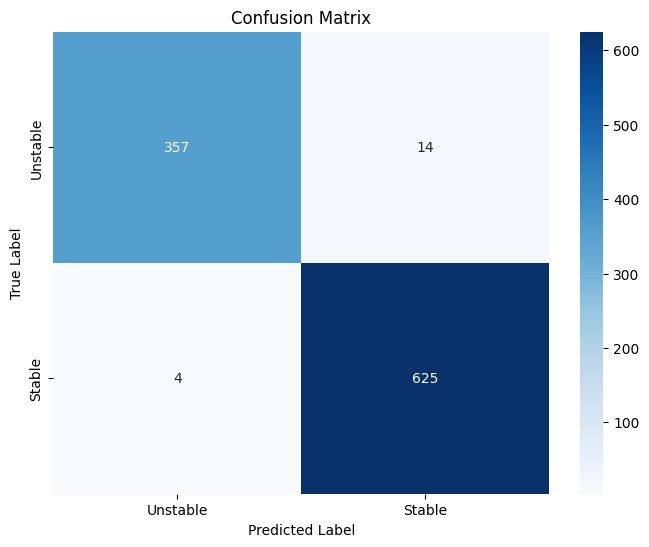


===== 评估完成 =====


In [3]:
import pandas as pd
import numpy as np
import catboost as cb
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                           roc_auc_score, roc_curve, precision_recall_curve, 
                           average_precision_score, f1_score)
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 设置基础路径
base_dir = '.'

model_path = f'{base_dir}/catboost/best_model/best.cbm'

print("===== 加载CatBoost模型并在测试集上评估 =====")

# 1. 加载测试数据
print("1. 加载测试数据...")
test_df = pd.read_csv(f'{base_dir}/data/test.csv')

# 准备数据
drop_columns = ['stab', 'stabf_encoded', 'stabf']
X_test = test_df.drop(drop_columns, axis=1)
y_test = test_df['stabf_encoded']

print(f"测试集维度: {X_test.shape}")
print(f"测试集类别分布: {y_test.value_counts().to_dict()}")

# 2. 特征工程（与训练时保持一致）
print("2. 应用特征工程...")
def create_features(X):
    """创建与训练时相同的特征"""
    X_new = X.copy()
    
    # 基本交互特征
    X_new['tau1_g1'] = X_new['tau1'] * X_new['g1']
    X_new['tau2_g2'] = X_new['tau2'] * X_new['g2']
    X_new['tau3_g3'] = X_new['tau3'] * X_new['g3']
    X_new['tau4_g4'] = X_new['tau4'] * X_new['g4']
    
    # 延迟比率
    X_new['tau_ratio'] = X_new[['tau1', 'tau2', 'tau3', 'tau4']].max(axis=1) / X_new[['tau1', 'tau2', 'tau3', 'tau4']].min(axis=1).replace(0, 0.001)
    
    return X_new

X_test_featured = create_features(X_test)

# 3. 选择指定特征
print("3. 选择指定特征...")
selected_features = [
    # 原始tau特征
    'tau1', 'tau2', 'tau3', 'tau4',
    # 原始g特征
    'g1', 'g2', 'g3', 'g4',
    # tau与g的交互项
    'tau1_g1', 'tau2_g2', 'tau3_g3', 'tau4_g4',
    # tau的比率特征
    'tau_ratio'
]

X_test_final = X_test_featured[selected_features]
print(f"最终测试特征维度: {X_test_final.shape}")
print(f"使用特征: {', '.join(selected_features)}")

# 4. 加载模型
print("4. 加载训练好的CatBoost模型...")
if not os.path.exists(model_path):
    print(f"错误: 模型文件不存在 {model_path}")
    exit()

model = cb.CatBoostClassifier()
model.load_model(model_path)
print(f"成功加载模型: {model_path}")

# 5. 在测试集上进行预测
print("5. 在测试集上进行预测...")
y_test_prob = model.predict_proba(X_test_final)[:, 1]  # 获取正类概率
y_test_pred = model.predict(X_test_final)              # 获取预测类别

# 6. 计算评估指标
print("6. 计算评估指标...")
test_auc = roc_auc_score(y_test, y_test_prob)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
test_f1_per_class = f1_score(y_test, y_test_pred, average=None)  # 每个类别的F1分数
avg_precision = average_precision_score(y_test, y_test_prob)

# 7. 打印详细评估结果
print("\n===== CatBoost模型在测试集上的性能 =====")
print(f"AUC: {test_auc:.4f}")
print(f"Accuracy: {test_acc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Macro F1 Score: {test_f1_macro:.4f}")
print(f"Weighted F1 Score: {test_f1_weighted:.4f}")
print(f"F1 Score - 不稳定类 (Class 0): {test_f1_per_class[0]:.4f}")
print(f"F1 Score - 稳定类 (Class 1): {test_f1_per_class[1]:.4f}")

# 8. 详细分类报告和混淆矩阵
print(f"\n===== 详细分类报告 =====")
print(classification_report(y_test, y_test_pred, target_names=['不稳定', '稳定'], digits=4))

print(f"\n===== 混淆矩阵 =====")
cm = confusion_matrix(y_test, y_test_pred)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Unstable', 'Stable'], 
            yticklabels=['Unstable', 'Stable'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


print(f"\n===== 评估完成 =====")